# Collaboration and Competion Project Solution

---

**Author:** _Ioannis Souflas_


**Description:** The objective of this project is to train two agents to control rackets to bounce a ball over a net using Unity's [Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) enviroment. For this purpose, a modified version of the original [DDPG](https://arxiv.org/pdf/1509.02971.pdf) algorithm will be used.


**External References:** [DDPG Algorithm - DeepMind](https://arxiv.org/pdf/1509.02971.pdf), [MADDPG Algorithm - DeepMind](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf)

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please that you have installed [Unity ML-Agents](https://pypi.org/project/unityagents/), [NumPy](http://www.numpy.org/), [Matplotlib](https://matplotlib.org/), [Collections](https://docs.python.org/2/library/collections.html), [Random](https://docs.python.org/2/library/random.html), [Time](https://docs.python.org/2/library/time.html) and [PyTorch](https://pytorch.org/).

In [1]:
from unityagents import UnityEnvironment 
import numpy as np 
import matplotlib.pyplot as plt
from collections import deque
import random
import time
import torch

# ddpg algorithm
from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

The current configuration is **Linux** (x86_64, headless).

In [2]:
env = UnityEnvironment(file_name="../../p3_collab-compet/Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The shape of the state space looks like:', states.shape)
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The shape of the state space looks like: (2, 24)
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


Note that this enviroment consists of 2 agents, as a results there are 2 different state spaces each having 3 vectors with 8 observations i.e. (2, 24).

### 3. DDPG Agent Training Pipeline

The `ddpg` function is making use of the `Agent` class in order to train the two different agents. Note that each each agent has a single objective i.e. to hit and pass the ball over the net.

In [5]:
def ddpg(n_episodes=10000, print_every=100, desired_reward=0.5, moving_average_lentgh=100, train_mode=True):
    
    episode_mean_scores = []                               
    scores_buffer = deque(maxlen=moving_average_lentgh)  
    moving_average = []       
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] 
        states = env_info.vector_observations                         
        scores = np.zeros(num_agents)                           
        agents.reset()
        while True:
            actions = agents.act(states, add_noise=True)         
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations          
            rewards = env_info.rewards                          
            dones = env_info.local_done                         
            agents.step(states, actions, rewards, next_states, dones)             
            states = next_states
            scores += rewards 
            if np.any(dones):                                   
                break
   
        episode_mean_scores.append(np.mean(scores))           
        scores_buffer.append(episode_mean_scores[-1])         
        moving_average.append(np.mean(scores_buffer))    
                
        if i_episode % print_every == 0:
            print('\rEpisode {}\tMean over an Episode: {:.2f}\tMoving Average: {:.2f}'.format(i_episode, episode_mean_scores[-1], moving_average[-1]))
                         
        if moving_average[-1] >= desired_reward and i_episode >= moving_average_lentgh and train_mode==True:
            print('\nAgents trained successfully!\tMoving Average ={:.2f} over the last {} episodes'.format(\
                                    moving_average[-1], moving_average_lentgh))            
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return episode_mean_scores, moving_average

# run the training loop
agents = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)
episodic_mean, moving_average = ddpg()

Episode 100	Mean over an Episode: -0.00	Moving Average: -0.00
Episode 200	Mean over an Episode: -0.00	Moving Average: 0.00
Episode 300	Mean over an Episode: -0.00	Moving Average: 0.00
Episode 400	Mean over an Episode: -0.00	Moving Average: -0.00
Episode 500	Mean over an Episode: -0.00	Moving Average: 0.01
Episode 600	Mean over an Episode: 0.10	Moving Average: 0.01
Episode 700	Mean over an Episode: -0.00	Moving Average: 0.01
Episode 800	Mean over an Episode: 0.05	Moving Average: 0.04
Episode 900	Mean over an Episode: 0.05	Moving Average: 0.09
Episode 1000	Mean over an Episode: 0.05	Moving Average: 0.11
Episode 1100	Mean over an Episode: 0.15	Moving Average: 0.13
Episode 1200	Mean over an Episode: 0.30	Moving Average: 0.16
Episode 1300	Mean over an Episode: -0.00	Moving Average: 0.18
Episode 1400	Mean over an Episode: 0.50	Moving Average: 0.25
Episode 1500	Mean over an Episode: 0.05	Moving Average: 0.38
Episode 1600	Mean over an Episode: 0.45	Moving Average: 0.24
Episode 1700	Mean over a

### 4. Plot of Rewards

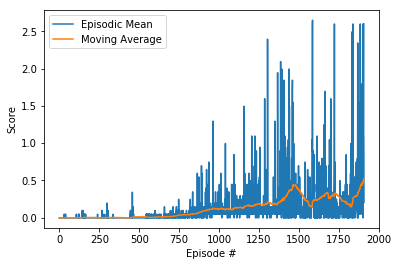

In [6]:
plt.plot(episodic_mean, label='Episodic Mean')
plt.plot(moving_average, label='Moving Average')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()